<a href="https://colab.research.google.com/github/victorm0202/temas_selectos_CD-23/blob/main/DL_secuencias2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes recurrentes para secuencias

Datos tomados de [Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption).

Partes del código fueron adaptadas de [Modern TS forecasting](https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python), así como [PyTorch Forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/index.html).

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
os.chdir('/content/drive/My Drive/Cursos/optativas_general/')
!pwd

/content/drive/My Drive/Cursos/optativas_general


In [3]:
import torch
import platform

if platform.system() == 'Darwin': #si es macOS
    av1 = torch.backends.mps.is_available()
    # this ensures that the current PyTorch installation was built with MPS activated.
    av2 = torch.backends.mps.is_built()
    if(av1==av2==True):
        print('MPS available?',av1,'MPS built?',av2)
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
else:
    #Check if GPU is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print("Device:",device)

Device: cuda


In [4]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('notebooks2023/')
from utils_sequences import get_data
from rnn_models import LSTM, GRU, RNN

# Data directory
data_dir = "Data/hourly_energy_consumption/"
#print(os.listdir(data_dir))

# Los datos

Usaremos los datos *Hourly Energy Consumption* ([link](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)):

"*PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. The hourly power consumption data comes from PJM's website and are in megawatts (MW).*"

In [6]:
files = os.listdir(data_dir)
ff = []
for f in files:
    # seleccionar los archivos que usaremos
    if f[-4:] != ".csv" or f == "pjm_hourly_est.csv":
        continue
    ff.append(f)
print(ff)

# Puedes seleccionar algunos archivos de datos, o usar toda la lista `ff`
files_data = [ff[index] for index in [0,10,11]]
files_data

['AEP_hourly.csv', 'DOM_hourly.csv', 'COMED_hourly.csv', 'EKPC_hourly.csv', 'FE_hourly.csv', 'DUQ_hourly.csv', 'DEOK_hourly.csv', 'DAYTON_hourly.csv', 'PJM_Load_hourly.csv', 'PJMW_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv']


['AEP_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv']

Los datos contienen originalmente el consumo de energía en megawatts por cada hora:

In [11]:
example_df = pd.read_csv(data_dir + ff[7], parse_dates=[0])
example_df

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0
...,...,...
121270,2018-01-01 20:00:00,2732.0
121271,2018-01-01 21:00:00,2724.0
121272,2018-01-01 22:00:00,2664.0
121273,2018-01-01 23:00:00,2614.0


Para éste ejercicio, se agregarán variables extras para intentar capturar patrones *estacionales* que puedan ayudar al pronóstico:

In [18]:
example_df['hour'] = example_df.apply(lambda x: x['Datetime'].hour,axis=1)
example_df['dayofweek'] = example_df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
example_df['month'] = example_df.apply(lambda x: x['Datetime'].month,axis=1)
example_df['dayofyear'] = example_df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
example_df = example_df.sort_values("Datetime").drop("Datetime",axis=1)
example_df

,DAYTON_MW,hour,dayofweek,month,dayofyear
2183,1621.0,1,4,10,275
2184,1536.0,2,4,10,275
2185,1500.0,3,4,10,275
2186,1434.0,4,4,10,275
2187,1489.0,5,4,10,275
...,...,...,...,...,...
116159,2554.0,20,3,8,214
116160,2481.0,21,3,8,214
116161,2405.0,22,3,8,214
116162,2250.0,23,3,8,214


## Datos de entrenamiento y prueba

Posteriormente, se aplicarán ciertas normalizaciones y se crearán datos de entrenamiento y prueba usando "ventanas deslizantes" de tamaño `lookback` mediante:

In [7]:
train_x, test_x, train_y, test_y, label_scalers = get_data(data_dir, ff, lookback=90)

  0%|          | 0/12 [00:00<?, ?it/s]

Observa las dimensiones del conjunto de entrenamiento:

In [ ]:
print(train_x.shape)

(980185, 90, 5)


Tenemos n observaciones de tamaño [90,5], los cuáles se formaron según se muestra en la siguiente figura:

![class](https://drive.google.com/uc?id=1DcK5HWJnKvOTZTbqg5MUVZE12hZxQotL)


Las variables dependientes e independientes se forman mediante una ventana deslizante como se ilustra en la figura siguiente:

![class](https://drive.google.com/uc?id=1nzuka-nrPta_AO8Y-6zoamhF1dQd1aWz)

Internamente, cada matriz de datos de entrenamiento queda con las siguientes dimensiones:

![figts](https://drive.google.com/uc?id=1cLSqP46QkvVe8jUdCTvRtgYdRNZLyOGg)


Finalmente, se separan conjuntos de entrenamiento y prueba (de acuerdo a cierta proporción `p`), de tal forma que, se obtiene **un solo conjunto de entrenamiento** concatenando los datos de entrenamiento de cada dataset, y se forman **un conjunto de datos de prueba para cada dataset**, al que se le aplica su respectiva transformación (esos datos se guardan en un diccionario). La siguiente figura ilustra el procedimiento.

![figts](https://drive.google.com/uc?id=1_t7yzOMuV2Q9BhCuGM8ptQW4HOP4MNlh)


Cada conjunto de entrenamiento tiene la siguiente estructura:

In [16]:
pd.DataFrame(train_x[0])

,0,1,2,3,4
0,0.173638,0.043478,0.666667,0.818182,0.750685
1,0.146084,0.086957,0.666667,0.818182,0.750685
2,0.131004,0.130435,0.666667,0.818182,0.750685
3,0.125109,0.173913,0.666667,0.818182,0.750685
4,0.130321,0.217391,0.666667,0.818182,0.750685
...,...,...,...,...,...
85,0.386124,0.608696,0.000000,0.818182,0.758904
86,0.382649,0.652174,0.000000,0.818182,0.758904
87,0.379049,0.695652,0.000000,0.818182,0.758904
88,0.374581,0.739130,0.000000,0.818182,0.758904


## Data loaders

In [8]:
batch_size = 512 #1024
train_data = TensorDataset(torch.from_numpy(train_x.astype(np.float32)), torch.from_numpy(train_y.astype(np.float32)))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

# Los modelos que usaremos

In [9]:
def trainRNN(train_loader, learn_rate, hidden_dim=256, n_layers = 2, EPOCHS=5):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of RNN model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #x = torch.from_numpy(x).to(depth_tensor.device)
            x = x.to(device)
            label = label.to(device)
            counter += 1
            h = h.data
            model.zero_grad()

            out, h = model(x, h)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def trainGRU(train_loader, learn_rate, hidden_dim=256, n_layers = 2, EPOCHS=5):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    # Instantiating the models
    model = GRU(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of GRU model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #x = torch.from_numpy(x).to(depth_tensor.device)
            x = x.to(device)
            label = label.to(device)
            counter += 1
            # GRU only has a single hidden state
            h = h.data
            model.zero_grad()

            out, h = model(x, h)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


def trainLSTM(train_loader, learn_rate, hidden_dim=256, n_layers = 2, EPOCHS=5):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    # Instantiating the models
    model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of LSTM model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #x = torch.from_numpy(x).to(depth_tensor.device)
            x = x.to(device)
            label = label.to(device)
            counter += 1
            # The hidden state for the LSTM is a tuple containing both the cell state and the hidden state
            h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x, h)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.perf_counter()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]).astype(np.float32))
        labs = torch.from_numpy(np.array(test_y[i]).astype(np.float32))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.perf_counter()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

# Entrenamiento y validación

## RNN simple

In [10]:
lr = 0.001
rnn_model = trainRNN(train_loader, lr, hidden_dim=256, n_layers=2)

Starting Training of RNN model
Epoch 1......Step: 200/1914....... Average Loss for Epoch: 0.005875115924573038
Epoch 1......Step: 400/1914....... Average Loss for Epoch: 0.003331185458955588
Epoch 1......Step: 600/1914....... Average Loss for Epoch: 0.0023916985708638096
Epoch 1......Step: 800/1914....... Average Loss for Epoch: 0.0018932608240356786
Epoch 1......Step: 1000/1914....... Average Loss for Epoch: 0.001580980839091353
Epoch 1......Step: 1200/1914....... Average Loss for Epoch: 0.0013657167743197835
Epoch 1......Step: 1400/1914....... Average Loss for Epoch: 0.0012053405658142375
Epoch 1......Step: 1600/1914....... Average Loss for Epoch: 0.0010839330897943
Epoch 1......Step: 1800/1914....... Average Loss for Epoch: 0.000986293236435611
Epoch 1/5 Done, Total Loss: 0.0009383197922245945
Time Elapsed for Epoch: 66.16665818499996 seconds
Epoch 2......Step: 200/1914....... Average Loss for Epoch: 0.00019031773539609275
Epoch 2......Step: 400/1914....... Average Loss for Epoch: 0

In [12]:
rnn_outputs, targets, rnn_sMAPE = evaluate(rnn_model, test_x, test_y, label_scalers)

OutOfMemoryError: ignored

NameError: ignored

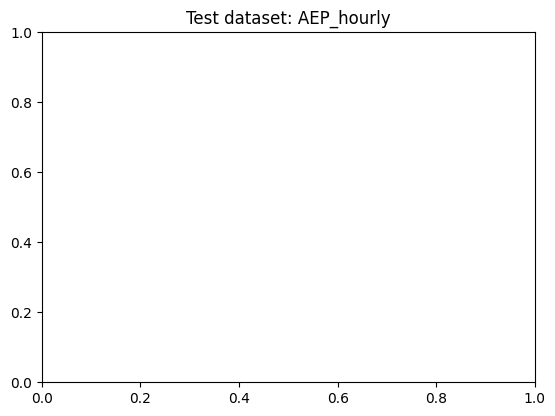

In [12]:
plt.figure(figsize=(14,10))
j = [0,2,5,10]
for i, val in enumerate(j):
  plt.subplot(2,2,i+1)
  plt.title(f"Test dataset: {list(test_x.keys())[val][:-4]}")
  plt.plot(rnn_outputs[val][-100:], "-o", color="g", label="Predicted")
  plt.plot(targets[val][-100:], color="b", label="Real")
  plt.ylabel('Energy Consumption (MW)')
  plt.legend()


## GRU

In [ ]:
lr = 0.001
gru_model = train(train_loader, lr, hidden_dim=256, n_layers=2)

Starting Training of GRU model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.006746046439511702
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.0037741267737874296
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0026840523618254035
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0021068634843686594
Epoch 1/5 Done, Total Loss: 0.0018096195211722355
Time Elapsed for Epoch: 1056.570475336 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0002435528907517437
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.00023793281518010189
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00022630112015273578
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.00021796288159748657
Epoch 2/5 Done, Total Loss: 0.00021175219934183595
Time Elapsed for Epoch: 755.1137240759999 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.0001772660818824079
Epoch 3......Step: 400/957....... Average Loss fo

In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 4.734132691999548
sMAPE: 0.26997210031064844%


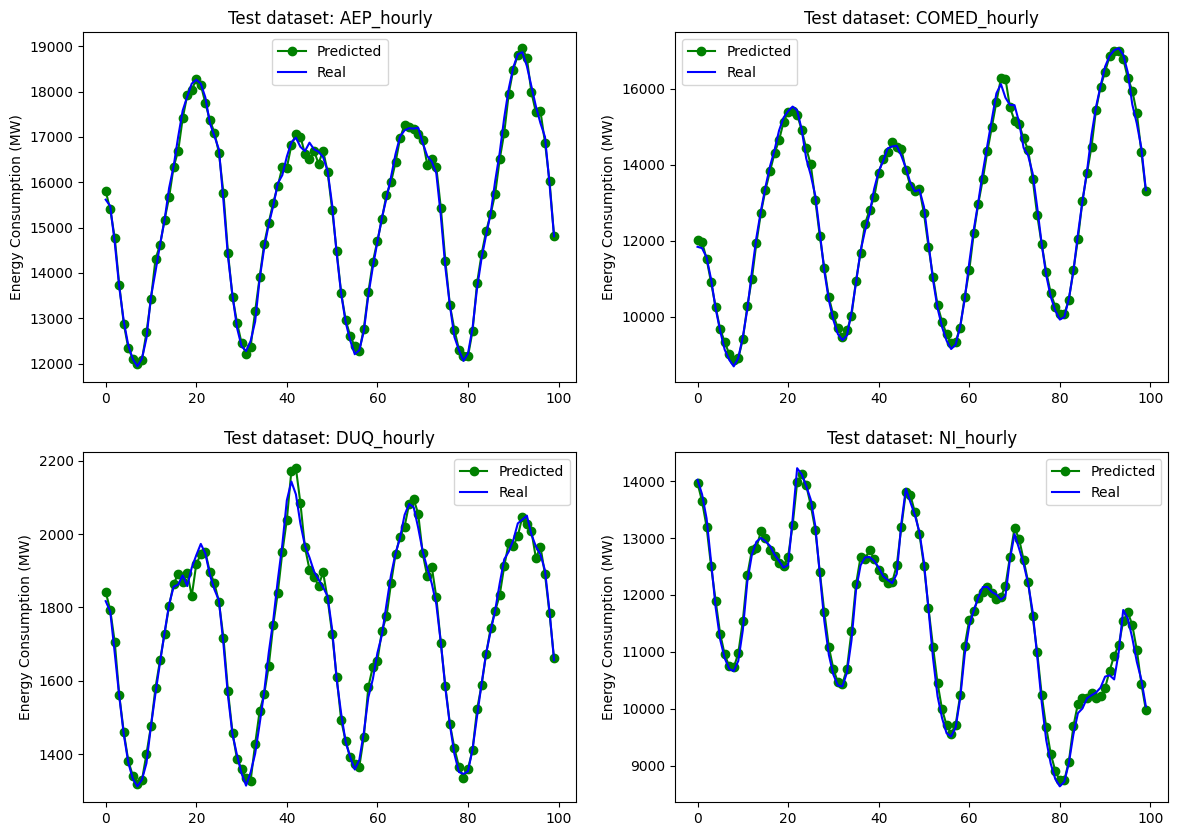

In [ ]:
plt.figure(figsize=(14,10))
j = [0,2,5,10]
for i, val in enumerate(j):
  plt.subplot(2,2,i+1)
  plt.title(f"Test dataset: {list(test_x.keys())[val][:-4]}")
  plt.plot(gru_outputs[val][-100:], "-o", color="g", label="Predicted")
  plt.plot(targets[val][-100:], color="b", label="Real")
  plt.ylabel('Energy Consumption (MW)')
  plt.legend()


## LSTM

In [ ]:
lr = 0.001
lstm_model = trainLSTM(train_loader, lr, hidden_dim=256, n_layers=2)

Starting Training of LSTM model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.011465665102587081
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.006344860835088184
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.004455180416747074
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0034600095182395307
Epoch 1/5 Done, Total Loss: 0.0029534755604679317
Time Elapsed for Epoch: 176.08068878199992 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0003241252373845782
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.00030240604904975044
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00028685243387978213
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.00027452607939267183
Epoch 2/5 Done, Total Loss: 0.00026547798174718064
Time Elapsed for Epoch: 176.43970741900011 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.0002128136310057016
Epoch 3......Step: 400/957....... Average Los

In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 5.676706369000385
sMAPE: 0.26243470492772764%


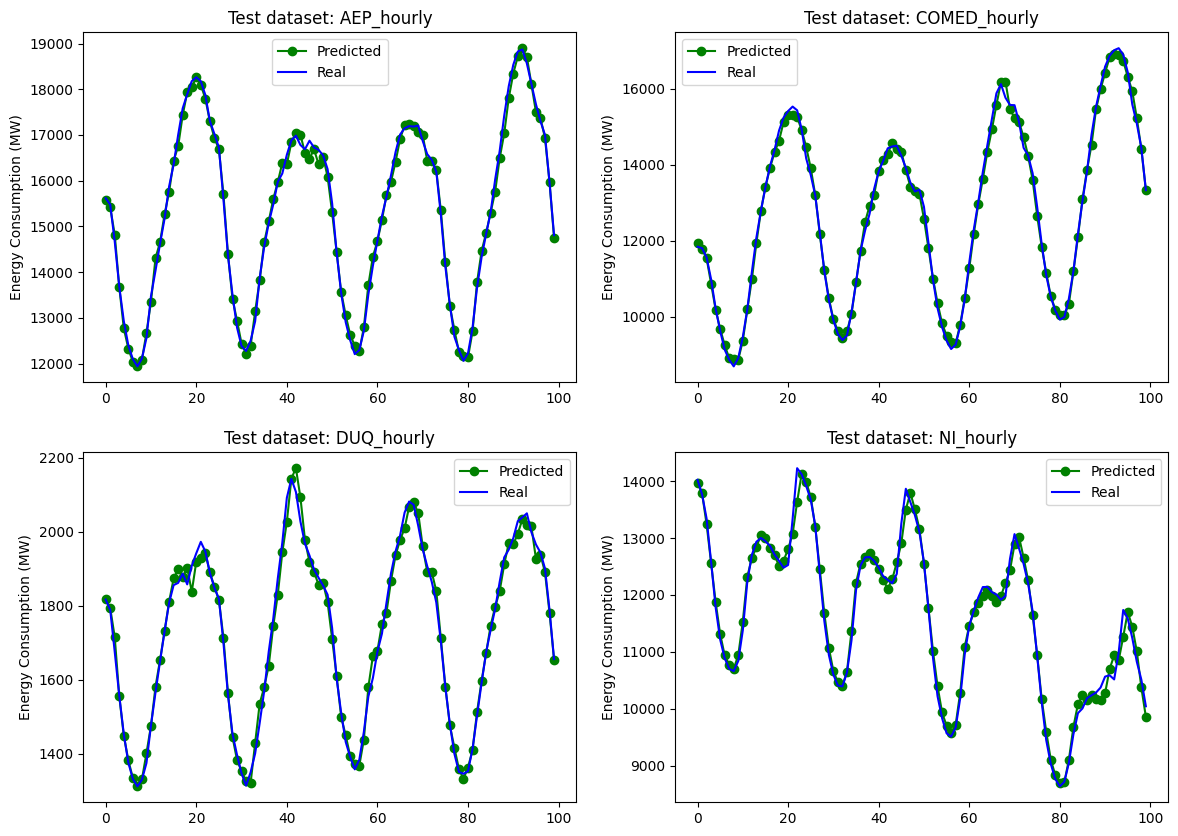

In [ ]:
plt.figure(figsize=(14,10))
j = [0,2,5,10]
for i, val in enumerate(j):
  plt.subplot(2,2,i+1)
  plt.title(f"Test dataset: {list(test_x.keys())[val][:-4]}")
  plt.plot(lstm_outputs[val][-100:], "-o", color="g", label="Predicted")
  plt.plot(targets[val][-100:], color="b", label="Real")
  plt.ylabel('Energy Consumption (MW)')
  plt.legend()
